# ADA - Final project
This notebook aims at giving technical explanations necessary to understand how the results given in the final report were found.

First off, the following commands allow you to retrieve the data necessary to run this notebook locally from the cluster used for this class.
1. Upload the files script.sh and script.py using the following command:  
```bash 
scp -r -p /path/to/script.py GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/script.py  
scp -r -p /path/to/script.sh GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/script.sh
```
2. Connect to the cluster using a second terminal and run the scripts:  
```bash 
ssh GASPAR@iccluster028.iccluster.epfl.ch  
sh script.sh script.py  
```
3. Store the output in the home folder:  
```bash 
hadoop fs -get /user/GASPAR/politics_2016_* file:///home/GASPAR
```
4. Download the data locally using the first terminal:  
```bash 
scp -r GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/politics_2016_* /local/path/to/folder
```

The retrieved dataset consists of several different features listed below:
* **author**: The username of the author of the comment.
* **author_flair_text**: Users can pick so-called *flairs* which are basically tags intended to briefly summarize the user.  They're different for each subreddit, and users can only pick one per subreddit.
* **body**: The content of the comment.
* **created_utc**: The date at which the comment was originally posted.
* **gilded**: Denotes if the comment received a gold. A gold is a form of gratification users can give one another. They're not common because gilding someone costs money.
* **id**: A unique ID that defines the comment.
* **link_id**: A unique ID that determines the post in which the comment was posted to.
* **parent_id**: A unique ID that determines to what the comment is responding to. If it starts with *t1*, the comment is a response to another comment. If it starts with *t3*, the comment is responding directly to the original post.
* **score**: The number of upvotes minus the number of downvotes the comment received.


## Imports

In [1]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

## Loading data

In [2]:
DATA_PATH = 'data/'

In [3]:
city_states = colors = pd.read_csv(DATA_PATH + 'us_cities_states_counties.csv', delimiter = '|')

In [4]:
politics_06 = pd.read_parquet(DATA_PATH + 'politics_2016_06/')
politics_07 = pd.read_parquet(DATA_PATH + 'politics_2016_07/')
politics_08 = pd.read_parquet(DATA_PATH + 'politics_2016_08/')
politics_09 = pd.read_parquet(DATA_PATH + 'politics_2016_09/')
politics_10 = pd.read_parquet(DATA_PATH + 'politics_2016_10/')
politics_11 = pd.read_parquet(DATA_PATH + 'politics_2016_11/')

## Cleaning data

Features are converted into appropriate format.  
Redundant data are removed as well.  
  
It is possible to retrieve if the comment was responding to a post or to another comment by matching *link_id* and *parent_id*.

In [5]:
# created_utc is converted to the datetime format
politics_06['created_utc'] = pd.to_datetime(politics_06['created_utc'], unit='s')
politics_07['created_utc'] = pd.to_datetime(politics_07['created_utc'], unit='s')
politics_08['created_utc'] = pd.to_datetime(politics_08['created_utc'], unit='s')
politics_09['created_utc'] = pd.to_datetime(politics_09['created_utc'], unit='s')
politics_10['created_utc'] = pd.to_datetime(politics_10['created_utc'], unit='s')
politics_11['created_utc'] = pd.to_datetime(politics_11['created_utc'], unit='s')

# author_flair_text is converted to a category
politics_06['author_flair_text'] = politics_06['author_flair_text'].astype('category')
politics_07['author_flair_text'] = politics_07['author_flair_text'].astype('category')
politics_08['author_flair_text'] = politics_08['author_flair_text'].astype('category')
politics_09['author_flair_text'] = politics_09['author_flair_text'].astype('category')
politics_10['author_flair_text'] = politics_10['author_flair_text'].astype('category')
politics_11['author_flair_text'] = politics_11['author_flair_text'].astype('category')

# remove unnecessary information in link_id and parent_id
politics_06['link_id'] = politics_06['link_id'].str.slice(3)
politics_07['link_id'] = politics_07['link_id'].str.slice(3)
politics_08['link_id'] = politics_08['link_id'].str.slice(3)
politics_09['link_id'] = politics_09['link_id'].str.slice(3)
politics_10['link_id'] = politics_10['link_id'].str.slice(3)
politics_11['link_id'] = politics_11['link_id'].str.slice(3)
politics_06['parent_id'] = politics_06['parent_id'].str.slice(3)
politics_07['parent_id'] = politics_07['parent_id'].str.slice(3)
politics_08['parent_id'] = politics_08['parent_id'].str.slice(3)
politics_09['parent_id'] = politics_09['parent_id'].str.slice(3)
politics_10['parent_id'] = politics_10['parent_id'].str.slice(3)
politics_11['parent_id'] = politics_11['parent_id'].str.slice(3)


In [6]:
politics_06.head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
0,wheresthecheese,NaN,I'm very glad I read that. The first well thou...,2016-06-01 00:00:00,0,d3r38dt,4lxbri,4lxbri,3
1,ifCreepyImJoking,NaN,"Eh, once you start adding qualifiers instead o...",2016-06-01 00:00:03,0,d3r38gd,4lwef1,d3r17zv,0
2,Sam_Munhi,NaN,How so? Clinton and Trump are the two most dis...,2016-06-01 00:00:12,0,d3r38n2,4lxbzg,d3r0tm6,4
3,VowOfKsitigarbha,NaN,Is he attacking the wrong target?,2016-06-01 00:00:12,0,d3r38n4,4lycd3,4lycd3,25
4,iAMADisposableAcc,NaN,"We can agree on that, although I guess we have...",2016-06-01 00:00:15,0,d3r38q3,4lw22m,d3r2rv0,2


Dataframes for each month are then concatenated into one massive Dataframe whose data types are just as expected.

In [7]:
politics = pd.concat([politics_06, politics_07, politics_08, politics_09, politics_10, politics_11]).reset_index()
politics['author_flair_text'] = politics['author_flair_text'].astype('category') #necessary to do it again

In [8]:
politics.dtypes

index                         int64
author                       object
author_flair_text          category
body                         object
created_utc          datetime64[ns]
gilded                        int64
id                           object
link_id                      object
parent_id                    object
score                         int64
dtype: object

In [9]:
politics.describe()

,index,gilded,score
count,1.086033e+07,1.086033e+07,1.086033e+07
mean,9.539365e+05,3.835981e-04,6.766324e+00
std,6.041415e+05,2.441999e-02,5.706394e+01
min,0.000000e+00,0.000000e+00,-8.620000e+02
25%,4.525130e+05,0.000000e+00,1.000000e+00
50%,9.050270e+05,0.000000e+00,1.000000e+00
75%,1.370547e+06,0.000000e+00,4.000000e+00
max,2.522909e+06,1.400000e+01,1.901100e+04


In [10]:
politics.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
0,0,wheresthecheese,NaN,I'm very glad I read that. The first well thou...,2016-06-01 00:00:00,0,d3r38dt,4lxbri,4lxbri,3
1,1,ifCreepyImJoking,NaN,"Eh, once you start adding qualifiers instead o...",2016-06-01 00:00:03,0,d3r38gd,4lwef1,d3r17zv,0
2,2,Sam_Munhi,NaN,How so? Clinton and Trump are the two most dis...,2016-06-01 00:00:12,0,d3r38n2,4lxbzg,d3r0tm6,4
3,3,VowOfKsitigarbha,NaN,Is he attacking the wrong target?,2016-06-01 00:00:12,0,d3r38n4,4lycd3,4lycd3,25
4,4,iAMADisposableAcc,NaN,"We can agree on that, although I guess we have...",2016-06-01 00:00:15,0,d3r38q3,4lw22m,d3r2rv0,2


In [11]:
print(set(politics['author_flair_text'].dropna()))
print(len(set(politics['author_flair_text'].dropna())))

{'I voted', 'Popcorn with extra salt.', 'Josh Marshall, Talking Points Memo founder', 'Vermont', 'Iowa', 'Popcorn Express', 'Arizona', 'Virginia', 'ColoradoCare YES', 'Montana', 'Dan Rolle (D-NV)', 'Chris Cataldo (MA)', 'Nicholas Schou, author of "Spooked"', 'NORML', 'Pennsylvania', 'Colorado Families for a Fair Wage', 'Texas', 'California | the AMA guy', 'Russ Feingold (D-WI)', 'Josh Hendler, NWWA', 'South Dakota', 'American Samoa', 'Rhode Island', 'Louisiana', 'North Carolina', 'Washington', 'Nebraska', 'AZ Healthy Working Families', 'Guam', 'Mainers for Fair Wages', 'District Of Colombia', 'extra butter', 'South Carolina', 'Hector Sigala, NWWA', 'New Hampshire', 'Eliot Nelson, Huffington Post political reporter', 'Popcorn', 'New Mexico', 'Massachusetts', 'Maine Ranked Choice Voting Campaign', 'Scott Wiener (D-CA)', 'Illinois', 'David Daley, Author - "Ratf**ked"', 'Maria Teresa Kumar, CEO of Voto Latino', 'Utah', 'America', 'Harri Hursti, creator of the Hursti Hack', 'Zephyr Teachout

In [12]:
state_full = set(np.array(city_states['State full'].dropna()))
print(state_full)
print(len(state_full))

{'Michigan', 'Maine', 'New Mexico', 'Vermont', 'Massachusetts', 'US Armed Forces Europe', 'Iowa', 'Tennessee', 'Illinois', 'Florida', 'Arizona', 'Delaware', 'Virgin Islands', 'Oregon', 'Virginia', 'Wisconsin', 'Marshall Islands', 'Missouri', 'Utah', 'Kentucky', 'Montana', 'Idaho', 'Pennsylvania', 'Palau', 'Texas', 'New Jersey', 'Puerto Rico', 'Hawaii', 'Oklahoma', 'Alabama', 'South Dakota', 'New York', 'US Armed Forces Pacific', 'American Samoa', 'Georgia', 'Washington, D.C.', 'Indiana', 'Rhode Island', 'Wyoming', 'Louisiana', 'West Virginia', 'Nevada', 'North Carolina', 'Colorado', 'Mississippi', 'North Dakota', 'Washington', 'Nebraska', 'Arkansas', 'Maryland', 'Alaska', 'Ohio', 'Minnesota', 'Northern Mariana Islands', 'Guam', 'Connecticut', 'Kansas', 'South Carolina', 'California', 'Federated States of Micronesia', 'New Hampshire'}
61


In [13]:
flair_politics = politics[politics['author_flair_text'].isin(state_full)]
print(set(flair_politics['author_flair_text']))
len(set(flair_politics['author_flair_text']))

{'Michigan', 'Maine', 'New Mexico', 'Vermont', 'Massachusetts', 'Iowa', 'Tennessee', 'Illinois', 'Florida', 'Arizona', 'Delaware', 'Oregon', 'Virginia', 'Wisconsin', 'Missouri', 'Utah', 'Kentucky', 'Montana', 'Idaho', 'Pennsylvania', 'Texas', 'New Jersey', 'Puerto Rico', 'Hawaii', 'Oklahoma', 'Alabama', 'South Dakota', 'New York', 'American Samoa', 'Indiana', 'Georgia', 'Rhode Island', 'Wyoming', 'Louisiana', 'West Virginia', 'Nevada', 'North Carolina', 'Colorado', 'Mississippi', 'Washington', 'Alaska', 'North Dakota', 'Nebraska', 'Maryland', 'Arkansas', 'Ohio', 'Minnesota', 'Guam', 'Connecticut', 'Kansas', 'South Carolina', 'California', 'New Hampshire'}


53

In [14]:
print(flair_politics.shape)
flair_politics.head()

(215850, 10)


,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
6147305,1669459,Qu1nlan,California,Hi `juno255`. Thank you for participating in /...,2016-09-30 02:31:46,0,d87sxgv,5552n9,5552n9,1
6147372,1669526,Qu1nlan,California,Hi `Alejandro_Last_Name`. Thank you for partic...,2016-09-30 02:33:36,0,d87t05c,5556yb,5556yb,1
6147390,1669544,Qu1nlan,California,Hi `ImNotJesus`. Thank you for participating i...,2016-09-30 02:33:57,0,d87t0p2,5548v7,5548v7,1
6147458,1669612,Qu1nlan,California,Hi `cmonshoe`. Thank you for participating in ...,2016-09-30 02:35:17,0,d87t2mq,5541x2,5541x2,1
6147507,1669661,Qu1nlan,California,Hi `abourne`. Thank you for participating in /...,2016-09-30 02:36:23,0,d87t4ep,554okj,554okj,1


## Processing data

In [15]:
def nlp_entity(body):
    """Creates a string with each named entity preceded by its corresponding tag and separated with a comma"""
    entities = ''
    for sent in nltk.sent_tokenize(body):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label'):
                 entities += (chunk.label() + ' ' + ' '.join(c[0] for c in chunk) + ',' )
    return entities[:-1]
                
def nlp_sentiment(body, sid=SentimentIntensityAnalyzer()):
    """Creates a string containing 4 numeric values corresponding to a sentiment analysis
    oredered as such compound, neg, neu, pos separated by a comma."""
    ss = sid.polarity_scores(body)
    sentiment = ""
    for k in sorted(ss):
        sentiment += '{},'.format(ss[k])
    return sentiment[:-1]

def nlp_wordcount(body, lemmatizer=nltk.WordNetLemmatizer(), stops=set(nltk.corpus.stopwords.words("english"))):
    """Returns a dictionnary with words frequency easily plottable."""
    fdist = nltk.FreqDist()
    tokens = nltk.word_tokenize(body)
    filtered_words = [word for word in tokens if word not in stops]
    for word in filtered_words:
        fdist[lemmatizer.lemmatize(word.lower())] += 1      
    return fdist

def sentiment_to_label(sentiment):
    ss = sentiment.split(',')
    compound = float(ss[0])
    if (compound > 0.2):
        return "Positive"
    elif (compound < -0.2):
        return "Negative"
    else:
        return "Neutral"

In [16]:
sample = politics.sample(10).copy()

sample['entity'] = sample['body'].apply(nlp_entity)
sample['sentiment'] = sample['body'].apply(nlp_sentiment)
sample['wordcount'] = sample['body'].apply(nlp_wordcount)
sample['label'] = sample['sentiment'].apply(sentiment_to_label)
sample

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
2526271,1233766,[deleted],NaN,[removed],2016-07-26 02:32:04,0,d5qxl3c,4uijjh,4uijjh,1,,"0.0,0.0,1.0,0.0","{'[': 1, 'removed': 1, ']': 1}",Neutral
1170557,1170557,omegawarrior3,NaN,Source?,2016-06-27 15:55:44,0,d4pyplx,4q3cdg,d4pudws,1,GPE Source,"0.0,0.0,1.0,0.0","{'source': 1, '?': 1}",Neutral
3306212,228054,Trump-Tzu,NaN,I mean realistically if you go give a big spee...,2016-08-04 15:02:32,0,d63zcm5,4w4vud,d63z480,-25,,"-0.438,0.08,0.92,0.0","{'i': 2, 'mean': 2, 'realistically': 1, 'go': ...",Negative
396214,396214,NebraskaGunOwner,NaN,I've told my die hard anti-second amendment fr...,2016-06-08 16:14:58,0,d4114yg,4n5t7f,4n5t7f,29,PERSON Clinton,"-0.2023,0.133,0.747,0.119","{'i': 2, ''ve': 1, 'told': 1, 'die': 1, 'hard'...",Negative
6840168,643092,RheagarTargaryen,NaN,It's a little bit of both. If he would have wo...,2016-10-10 06:01:16,0,d8lkalt,56psun,d8lh71p,4,"ORGANIZATION DNC,PERSON Bernie Sanders,PERSON ...","0.9727,0.029,0.806,0.165","{'it': 1, ''s': 2, 'little': 1, 'bit': 1, '.':...",Positive
3435702,357544,SvenHudson,NaN,&gt; They're ignoring demonstrated incompetenc...,2016-08-07 04:16:46,0,d67gdy6,4wi2tx,d67gank,0,,"-0.7184,0.353,0.647,0.0","{'&': 1, 'gt': 1, ';': 1, 'they': 1, ''re': 1,...",Negative
1229936,1229936,Huckleberry_Win,NaN,Naked pics online? That's disgusting! On a web...,2016-06-29 04:57:38,0,d4s73t2,4qdopy,4qdopy,2,,"-0.686,0.237,0.763,0.0","{'naked': 1, 'pic': 1, 'online': 1, '?': 4, 't...",Negative
1365594,73089,[deleted],NaN,[removed],2016-07-03 14:36:52,0,d4xogsa,4r0a1f,d4xik3v,1,,"0.0,0.0,1.0,0.0","{'[': 1, 'removed': 1, ']': 1}",Neutral
6748330,551254,Iamtheoneclinton,NaN,"Hmm, and some comment he made a long time ago ...",2016-10-10 00:50:42,0,d8l6r35,56p08c,d8l4adl,1,GPE Hmm,"0.34,0.0,0.854,0.146","{'hmm': 1, ',': 1, 'comment': 1, 'made': 1, 'l...",Positive
4976007,498161,Bigbrass,NaN,"This thread has over 10,000 comments, and you ...",2016-09-12 04:10:18,0,d7j666e,52asml,d7j3squ,2,,"0.0,0.0,1.0,0.0","{'this': 1, 'thread': 2, '10,000': 1, 'comment...",Neutral


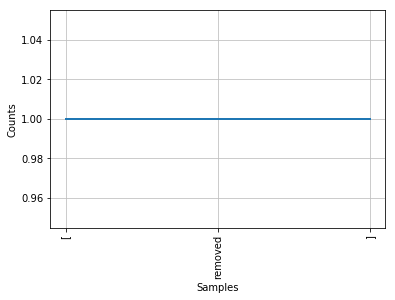

In [17]:
sample.iloc[0]['wordcount'].plot()

### Words positive or negative
Using flair only dataset

In [18]:
def get_word_count(df, sentiment):
    """ Get the word count according to the sentiment. Can be 'Positive', 'Negative', 'Neutral' or 'None' """
    if sentiment != 'None':
        filtered_df = df[df['label'] == sentiment]
    else:
        filtered_df = df.copy()
    fdists = list(filtered_df['wordcount'])
    tot_fd = nltk.FreqDist()
    for fdist in fdists:
        for key in fdist:
            tot_fd[key] += fdist.get(key)
            
    return tot_fd

sample_sorted_score = flair_politics.copy().sample(5000).sort_values(by=['score'], ascending=False)
sample_sorted_score['entity'] = sample_sorted_score['body'].apply(nlp_entity)
sample_sorted_score['sentiment'] = sample_sorted_score['body'].apply(nlp_sentiment)
sample_sorted_score['wordcount'] = sample_sorted_score['body'].apply(nlp_wordcount)
sample_sorted_score['label'] = sample_sorted_score['sentiment'].apply(sentiment_to_label)
sample_sorted_score.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
10423433,2086017,6p6ss6,California,"This Thanksgiving, I give thanks to the Native...",2016-11-23 17:18:07,0,dacmuqr,5ei983,5ei983,2782,ORGANIZATION Native Americans,"-0.4404,0.235,0.648,0.117","{'this': 1, 'thanksgiving': 1, ',': 2, 'i': 1,...",Negative
6995855,798779,CNegan,Texas,I genuinely hope that all of his supporters do...,2016-10-12 02:30:51,0,d8o9dba,571wsx,571wsx,1793,,"0.7003,0.0,0.756,0.244","{'i': 1, 'genuinely': 1, 'hope': 1, 'supporter...",Positive
10407419,2070003,6p6ss6,California,"First politicize science. Climate science, evo...",2016-11-23 13:31:05,0,dacdfno,5egzfk,5egzfk,1574,"PERSON Climate,ORGANIZATION Luddite","-0.3464,0.124,0.82,0.057","{'first': 1, 'politicize': 1, 'science': 4, '....",Negative
7720886,1523810,lofi76,Colorado,As a woman who's thankfully never needed to ab...,2016-10-21 13:21:08,0,d91p66q,58mjza,d91n99e,1423,"ORGANIZATION Pap,GPE Abhorrent","0.4019,0.062,0.819,0.118","{'a': 1, 'woman': 3, ''s': 2, 'thankfully': 1,...",Positive
7606136,1409060,WistfulAether,California,Congratulations to President Hillary Clinton,2016-10-20 02:37:28,0,d8zrs1d,58eh18,58eh18,1236,PERSON Hillary Clinton,"0.5994,0.0,0.506,0.494","{'congratulation': 1, 'president': 1, 'hillary...",Positive


#### Taking good scores into account

In [19]:
good_score = sample_sorted_score[sample_sorted_score['score'] > 1000].copy()

In [20]:
word_positive_good = get_word_count(good_score, 'Positive')
word_negative_good = get_word_count(good_score, 'Negative')
word_count_good = get_word_count(good_score, 'None')

In [21]:
word_positive_good.most_common(10)

[('.', 5),
 ('i', 4),
 (',', 4),
 ('woman', 3),
 ("'s", 2),
 ('exam', 2),
 ("n't", 2),
 ('genuinely', 1),
 ('hope', 1),
 ('supporter', 1)]

In [22]:
word_negative_good.most_common(10)

[('.', 13),
 (',', 9),
 ('i', 8),
 ('hated', 5),
 ('science', 4),
 ('like', 3),
 ('this', 2),
 ('people', 2),
 ('first', 2),
 ('favor', 2)]

In [23]:
word_count_good.most_common(10)

[('.', 18),
 (',', 13),
 ('i', 12),
 ('hated', 5),
 ('science', 4),
 ("n't", 3),
 ('like', 3),
 ('woman', 3),
 ('this', 2),
 ('people', 2)]

#### Bad scores

In [24]:
bad_score = sample_sorted_score[sample_sorted_score['score'] < 0].copy()

bad_score.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
9675708,1338292,VelvetElvis,Tennessee,She's literally his daughter. She gets protec...,2016-11-13 19:48:54,0,d9ysgkq,5cr08j,d9ys9w2,-1,,"-0.6249,0.194,0.806,0.0","{'she': 2, ''s': 1, 'literally': 1, 'daughter'...",Negative
6354669,157593,thegoodvibe,Illinois,In high level positions? yes.,2016-10-04 02:00:49,0,d8czpf9,55pphk,d8cxm5x,-1,,"0.4019,0.0,0.597,0.403","{'in': 1, 'high': 1, 'level': 1, 'position': 1...",Positive
7647043,1449967,rediced,New Jersey,Chinese steel?,2016-10-20 11:52:56,0,d906341,58ekat,d8zu0z7,-1,GPE Chinese,"0.0,0.0,1.0,0.0","{'chinese': 1, 'steel': 1, '?': 1}",Neutral
6559566,362490,Arthrawn,Indiana,Oh right. The guy who can't name a world leade...,2016-10-07 16:57:27,0,d8i33nn,56bxy0,d8i1u6n,-1,PERSON Harambe,"0.6908,0.0,0.729,0.271","{'oh': 1, 'right': 1, '.': 3, 'the': 1, 'guy':...",Positive
10534399,2196983,gonzoparenting,California,They can choose from the top three vote getter...,2016-11-25 15:59:46,0,daf5hpj,5ettea,daf4rbs,-1,"PERSON Trump,PERSON Clinton,PERSON Pence,GPE K...","-0.0418,0.049,0.905,0.045","{'they': 2, 'choose': 1, 'top': 1, 'three': 1,...",Neutral


In [25]:
word_positive_bad = get_word_count(bad_score, 'Positive')
word_negative_bad = get_word_count(bad_score, 'Negative')
word_count_bad = get_word_count(bad_score, 'None')

In [26]:
word_positive_bad.most_common(10)

[('.', 128),
 (',', 77),
 ('i', 45),
 ("'s", 22),
 ("n't", 19),
 ('?', 17),
 (':', 11),
 ('trump', 11),
 ('like', 10),
 ('hillary', 10)]

In [27]:
word_negative_bad.most_common(10)

[('.', 189),
 (',', 111),
 ("n't", 53),
 ('i', 51),
 ("'s", 47),
 ('?', 29),
 ('&', 22),
 (';', 22),
 ('trump', 19),
 ('``', 17)]

In [28]:
word_count_bad.most_common(10)

[('.', 419),
 (',', 237),
 ('i', 112),
 ("'s", 92),
 ("n't", 86),
 ('?', 58),
 ('trump', 42),
 ('&', 39),
 (';', 39),
 ("''", 34)]

#### Compare good and bad
Which one are in both sets?

In [29]:
both = []
good_only = nltk.FreqDist()
for good in word_count_good:
    if good in word_count_bad:
        both.append(good)
    else:
        good_only[good] = word_count_good.get(good)

In [30]:
both[:10]

['this',
 ',',
 'i',
 'give',
 'thanks',
 'native',
 'american',
 'people',
 'standing',
 '.']

In [31]:
good_only.most_common(10)

[('hated', 5),
 ('exam', 2),
 ('thanksgiving', 1),
 ('protesting', 1),
 ('fight', 1),
 ('november', 1),
 ('28th', 1),
 ('single', 1),
 ('politicize', 1),
 ('cell', 1)]

In [32]:
bad_only = nltk.FreqDist()
for bad in word_count_bad:
    if bad not in word_count_good:
        bad_only[bad] = word_count_bad.get(bad)

In [33]:
bad_only.most_common(10)

[('?', 58),
 ('trump', 42),
 ('gt', 33),
 (':', 31),
 ('...', 30),
 ('the', 26),
 ('would', 24),
 ('election', 21),
 (')', 21),
 ('(', 20)]

## Entities

In [34]:
def get_score(row, firstName, lastName, out_states):
    current_state = row['author_flair_text']
    if firstName in row['entity'] or lastName in row['entity']:
        if row['label'] == 'Positive':          
            out_states.loc[current_state, 'score_'+lastName] += 1
        elif row['label'] == 'Negative':
            out_states.loc[current_state, 'score_'+lastName] -= 1

In [35]:
state_list = list(set(state_full))
state_df = pd.DataFrame(state_list, columns=['name'])
state_df.set_index('name', inplace=True)
state_df['score_Trump'] = 0
state_df['score_Clinton'] = 0

sample_sorted_score.apply(get_score, firstName='Donald', lastName='Trump', out_states=state_df, axis=1)
sample_sorted_score.apply(get_score, firstName='Hillary', lastName='Clinton', out_states=state_df, axis=1)


state_df.head()

,score_Trump,score_Clinton
name,,
Michigan,-5,3
Maine,1,0
New Mexico,0,1
Vermont,0,1
Massachusetts,5,-1


In [36]:
#TODO plot

## Visualizing data

To get a feel for the dataset, a histogram with the number of comments for each day is plotted.

In [37]:
# computation of the number of days the dataset spans
days = (politics.iloc[-1].created_utc - politics.iloc[0].created_utc).days + 1

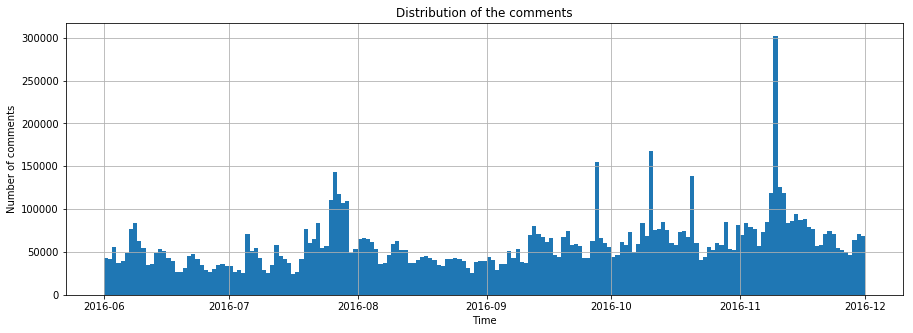

In [38]:
plt.figure(figsize=(15,5))
plt.grid()
plt.hist(politics['created_utc'], bins=days)
plt.ylabel('Number of comments')
plt.xlabel('Time')
plt.title('Distribution of the comments')
plt.show()